In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import re
import scipy.constants as c
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import welch
from scipy.signal import find_peaks
from scipy.signal import periodogram
from scipy.interpolate import interp1d
import scipy.signal as sig
import math
import string
import pandas as pd

# Gui stuff.
import tkinter
from PIL import ImageTk, Image
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
#plt.style.use("dark_background")

# Multithreading
from threading import Thread


# Split into like 1000 sections for each trace, average those and find variance of each slice.
# Allan variance (do it).

In [2]:
# Functions to be fitted.
def sqq(omega,omegaq,Gammacm,Tcm,M):
    return ((abs(Gammacm)*c.k*abs(Tcm))/(np.pi*abs(M)))/((omega**2-abs(omegaq)**2)**2+(abs(Gammacm)**2)*(abs(omega)**2))

def ssqq(omega,omegaq,Gammacm,a):
    return ((abs(Gammacm)*abs(a))/((omega**2-abs(omegaq)**2)**2+(abs(Gammacm)**2)*(abs(omega)**2)))

In [3]:
# Misc.
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def progress_bar(i,L,w):
    pr = i/L
    print(2*w*' ', end = '\r')
    print('[{}{}]{}/100%'.format(int(w*pr)*'#',int(w*(1-pr))*'.',round(100*pr,1)),end='\r')

def count_e(nested_list):
    return sum(count_elements_nested_list(item) if isinstance(item, list) else 1 for item in nested_list)

class Rod_Gamas:
    def __init__(self, T_s, l, R, D, p):
        self.l = l
        self.R = R
        self.p = p
        self.T = 300
        self.M = np.pi * R**2 * l * D
        self.alpha_c = 0.65 # Assuming surrounding gas is N_2.
        self.gamma_s = np.sqrt(T_s/self.T) # T_s = surface temp, # T = gas temp; (maybe ~1).
        self.m = 28.0134/(1000*c.N_A) # Mass of gas molecule (N_2).
        self.ng  = p/(c.k*self.T) # Gas density.

    def cm_t(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (2+self.alpha_c(-1/2 + np.pi*self.gamma_s/4 + self.R/self.l))

    def cm_p(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (4*self.R/self.l+self.alpha_c*(1 - 2*self.R/self.l + np.pi*self.gamma_s*self.R/(2*self.l)))

    def rot_t(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (self.l**2/(3*self.R**2 + self.l**2))* (2 + 12*(self.R/self.l)**3 + self.alpha_c*(-1/2 + np.pi*self.gamma_s/4 + 3*self.R/self.l + 6*(self.R/self.l)**2 + (3*np.pi*self.gamma_s/2 - 6)*(self.R/self.l)**3))

    def rot_p(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * self.alpha_c*(2+ self.R/self.l)
 
class data_loader:
    def __init__(self, dataloc):
        fileNames = [f for f in listdir(dataloc) if isfile(join(dataloc, f)) and f[-4:] == '.mat' and f[:8].isnumeric()]
        fileNames.sort(key=lambda f: int(re.sub('\D', '', f)))
        fileNames = fileNames[:-1] # Cut the last file off as it is an unpredicatble length.

        self.d = [loadmat(dataloc+'\\'+ fileName) for fileName in fileNames]

class data_processing:
    def __init__(self, d, CH):
        self.d = d
    
        self.CH = CH

        self.Ti = d[0]['Tinterval'][0,0]
        self.l = d[0]['Length'][0,0]
        
        self.split_data = []
        self.processed_data = []

    def plot_time_series(self, ax, ax2):
        xs = np.linspace(0,self.l*self.Ti,self.l)
        points = 1000 #Number of points on final graph
        points_sep = round(len(xs)/points)
        if points_sep < 1:
            points_sep = 1
        ax.scatter(xs[::points_sep], self.d[0][self.CH][::points_sep], color='tab:red', s = 1, alpha = 0.8)
        ax.set_title('Time Series Data (CH {})'.format(self.CH))
        ax2.set_xlabel('Time (s)')
        ax.set_ylabel('Voltage (V)')
        ax.set_xlim([xs[0],xs[-1]])
        ax2.set_xlim(ax.get_xlim())
        
    def plot_full_PSD(self, ax, ax2):
        #plt.figure(figsize=(10, 3.5), dpi=80)
        xf, pxx = periodogram(self.d[0][self.CH][:,0],fs=1/self.Ti)
        ax.semilogy()
        points = 1000 #Number of points on final graph
        points_sep = round(len(xf)/points)
        if points_sep < 1:
            points_sep = 1
        ax.scatter(xf[::points_sep], pxx[::points_sep], color='black', s = 1, alpha = 0.8 )
        ax.set_title('PSD (CH {})'.format(self.CH))
        ax2.set_xlabel('Freq. (Hz)')
        ax.set_ylabel('Voltage ($V^2/Hz$)')
        ax.set_xlim([xf[0],xf[-1]])
        ax2.set_xlim(ax.get_xlim())
        
    def splitting_data(self, freq = 3e5, osc = 1e4):
        self.split_data = []
        split_length = int(self.l*self.Ti/(osc*(1/freq)))
        for i in range(len(self.d)):
            r = (self.d[0][self.CH])[:,0].shape[0]%split_length
            self.split_data.append(np.split((self.d[0][self.CH])[:-r,0], split_length))
            
        self.split_data = np.asarray(self.split_data)
    
    def average(self):
        # Find Summed PSDs.
        lpxx = []
        # For each channel, adds all periodograms generated from d seperate runs together.
        for i in range(len(self.d)):
            for j in range(self.split_data.shape[1]):
                # This is done to limit too much memory allocation.
                if i == 0: 
                    xf, pxx = periodogram(self.split_data[i,j,:],fs=1/self.Ti)
                else:
                    _, pxx = periodogram(self.split_data[i,j,:],fs=1/self.Ti)
                lpxx.append(pxx[1:])
                
        lpxx = np.asarray(lpxx)
        mpxx = np.mean(lpxx, axis= 0 )
        spxx = np.std(lpxx, axis= 0 )
        epxx = np.std(lpxx, axis= 0 )/np.sqrt(lpxx.shape[0])
        self.processed_data = [xf[1:], mpxx, spxx, epxx]

    def plot_mean_errorbars(self, ax, ax2):
        xf, mpxx, epxx = self.processed_data[0], self.processed_data[1], self.processed_data[3]
        ax.semilogy()
        points = 1000 #Number of points on final graph
        points_sep = round(len(xf)/points)
        if points_sep < 1:
            points_sep = 1
        ax.errorbar(xf[::points_sep], mpxx[::points_sep], yerr = epxx[::points_sep], marker='', linestyle='', color='black', ms = 1, alpha = 0.8 )
        ax.set_title('PSD Data (log10)')
        ax2.set_xlabel('Freq. (Hz)')
        ax.set_ylabel('PSD ($V^2/Hz$)')
        ax.set_xlim([xf[0],xf[-1]])
        ax2.set_xlim(ax.get_xlim())

class fit_data:
    def __init__(self, processed_data):
        self.processed_data = processed_data
        self.peak_params = [[],[]]
        self.popt = []
        self.pcov = []
        self.labels = []
        self.p = 0
        
        
    def find_peaks(self, width_tuning, ax, ax2, peak_lim = 50):
        #width_tuning = 11
        #peak_lim = 50
        peak_list = []
        amp_list = []
        
        xf = self.processed_data[0]
        mpxx = self.processed_data[1]

        #progress_bar(i,len(CH),40)
        #plt.figure(figsize=(10, 3.5), dpi=80)
        ax.semilogy()
        points = 1000 #Number of points on final graph
        points_sep = round(len(xf)/points)
        if points_sep < 1:
            points_sep = 1
        ax.scatter(xf[::points_sep], mpxx[::points_sep],color='black', s = 1)
        ax.set_title('PSD Data (log10)')
        ax2.set_xlabel('Freq. (Hz)')
        ax.set_ylabel('PSD ($V^2/Hz$)')
        ax.set_xlim([xf[0],xf[-1]])
        ax2.set_xlim(ax.get_xlim())
        peaks = find_peaks(mpxx, width = width_tuning)[0]
        #print('Peaks: {}'.format(len(peaks)))
        if len(peaks) > peak_lim:
            print('Error: Too Many Peaks')
        for j in range(len(peaks)):
            ax.axvline(x=xf[peaks[j]],color='tab:red')
            peak_list.append(xf[peaks[j]])
            amp_list.append(mpxx[peaks[j]])
        #peaks = np.append(peaks, [1200]) #Temporary additional peak
        #peak_list.append(55000) #Temporary additional peak
        #amp_list.append(2e-9) #Temporary additional peak
        self.p = len(peak_list)
        self.peak_params = [self.p, peaks, peak_list, amp_list]
        plt.show()
        
    def fit_multipeak(self, a, b, c, d, gamma, amp, peak_search_area = 250):
        xf, mpxx, spxx, epxx = self.processed_data[0], self.processed_data[1], self.processed_data[2], self.processed_data[3]
        p, peaks, peak_list, amp_list = self.peak_params

        # Build multi func.
        vs = 'omega, a, b, c, d,'
        funcString1 = "def multi_peak({}):"
        funcString2 = ' a/((omega-d)**b) + c +'
        for i in range(p):
            vs+=' omegaq{}, Gammacm{}, a{},'.format(i,i,i)
            funcString2 += ' ssqq(omega, omegaq{}, Gammacm{}, a{}) +'.format(i,i,i)
        funcString2 = funcString2[:-2]
        funcString1 = funcString1.format(vs)
        funcString = funcString1 + '\n return' +  funcString2

        exec(funcString, globals())
        
        lowerBound = ()
        upperBound = ()
        lowerBound += (0,)
        upperBound += (np.inf,)
        lowerBound += (0.01,)
        upperBound += (3,)
        lowerBound += (0,)
        upperBound += (np.inf,)
        lowerBound += (0,)
        upperBound += (np.inf,)
        #Initial Guesses
        p0g = [a, b, c, d]
        for i in range(p):
            lb = peak_list[i]-peak_search_area
            if lb < 0:
                lb = 0
            ub = peak_list[i]+peak_search_area
            if ub > xf[-1]:
                ub = xf[-1]
            lowerBound += (lb,)
            upperBound += (ub,)
            p0g.append(peak_list[i]) # Peak pos guesses.
            lowerBound += (0,)
            upperBound += (np.inf,) 
            p0g.append(gamma) # Gamma Guess
            lowerBound += (0,)
            upperBound += (np.inf,)
            p0g.append(amp_list[i]*amp*1e14) # amp guesses
        #Fitting
        self.popt, self.pcov = curve_fit(multi_peak, xf, mpxx,
                               sigma = spxx, absolute_sigma = True, bounds = (lowerBound, upperBound), p0 = p0g)

    def peak_identification(self, bounds = 1000):
        popt = self.popt
        pcov = self.pcov
        peaks = self.peak_params[1]
        amp_list = self.peak_params[3]
        #Harmonic identification
        #bounds = 1000 #bound on identification for harmonics
        h_order = 1 #max order to identify, fundamental is order 1
        harmonic = np.zeros((len(peaks),h_order))
        for i in range(len(peaks)):
            for j in range(len(peaks)):
                for k in range(h_order):
                    if popt[4+3*i] >= (k+2)*popt[4+3*j] - bounds and popt[4+3*i] <= (k+2)*popt[4+3*j] + bounds:
                        harmonic[i,k] = j
        #Sideband identification
        bounds = 1500 #bound on identification for sidebands
        harm = np.sum(harmonic,1) # used to ignore harmonics
        s_order = 2 #order of sidebands
        s = [y for y in range(-1*s_order, s_order+1, 1) if y!=0]
        sideband = np.zeros((len(peaks),2,2*s_order))
        for i in range(len(peaks)):
            for j in range(len(peaks)):
                for k in range(len(peaks)):
                    for l in range(len(s)):
                        if popt[4+3*i] >= popt[4+3*j] + s[l]*popt[4+3*k] - bounds and popt[4+3*i] <= popt[4+3*j] + s[l]*popt[4+3*k] + bounds and (i!=j and i>k) and j!=k and harm[i] == 0 and harm[j] == 0 and harm[k] == 0 and not (i in harmonic):
                            if amp_list[i] < amp_list[j]: #or amp_list[i] > amp_list[int(sideband[i,1,j])]:
                                sideband[i,0,l] = j
                                sideband[i,1,l] = k
        #removing fake sidebands/finding real peaks
        side = np.sum(sideband, 2)
        for i in range(len(peaks)):
            for j in range(len(s)):
                if sideband[i,0,j] != 0:
                    if side[int(sideband[i,0,j]),0] != 0 or side[int(sideband[i,1,j]),0] != 0:
                        sideband[i,0,j] = 0
                        sideband[i,1,j] = 0
        
        #labelling
        alph = list(string.ascii_uppercase)
        labels = list(alph[0:len(peaks)])
        j = 0
        for i in range(len(peaks)):
            if harm[i] == 0 and side[i,0] == 0:
                labels[i] = alph[j]
                j += 1
        for i in range(len(peaks)):
            if harm[i] != 0:
                for k in range(h_order):
                    labels[i] = str(int((k+2))) + labels[int(harmonic[i,k])];
            elif side[i,0] != 0:
                for k in range(len(s)):
                    if sideband[i,0,k] != 0:
                        if s[k] < 0:
                            sign = '-' + str(int(abs(s[k])))
                        elif s[k] > 0:
                            sign = '+' + str(int(abs(s[k])))
                        if labels[i] != alph[i]:
                            labels[i] += '/' + '\n' + labels[int(sideband[i,0,k])] + sign + labels[int(sideband[i,1,k])]
                        else:
                            labels[i] = labels[int(sideband[i,0,k])] + sign + labels[int(sideband[i,1,k])]
        self.labels = labels
    
    def plot(self, ax, ax2, auto_label = True, label_toggle = True):
        xf, mpxx, spxx, epxx = self.processed_data[0], self.processed_data[1], self.processed_data[2], self.processed_data[3]
        p, peaks, peak_list, amp_list = self.peak_params
        popt = self.popt
        pcov = self.pcov
        if label_toggle and auto_label:
            self.peak_identification()
        elif label_toggle:
            alph = list(string.ascii_uppercase)
            self.labels = list(alph[0:p])
        #Plotting
        points = 1000 #Number of points on final graph
        point_sep = round(len(xf)/points)
        if point_sep < 1:
            point_sep = 1
        #Plot initialisation ax is main psd and fit, ax2 is residual plot
        fig = plt.figure(figsize=(10, 3.5), dpi=150)
        #ax = fig.add_axes((0, 0, 1, 1))
        #ax2 = fig.add_axes((0, -0.21, 1, 0.2))
        ax.semilogy() #y log
        ax.tick_params(axis = 'x', labelsize = 0, bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax2.tick_params(bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax.set_xlim([0,xf.max()])
        ax2.set_xlim(ax.get_xlim())
        ax2.set_ylim([-50,50])
        ax.set_title('PSD Data')
        ax2.set_xlabel('Freq. (Hz)')
        ax.set_ylabel('PSD ($V^2/Hz$)')
        ax.errorbar(xf[::point_sep], mpxx[::point_sep], yerr = epxx[::point_sep], marker='.', linestyle='',
                     color='black', alpha=0.7, ms = 2, linewidth = 0, elinewidth = 1,
                     capsize = 1, ecolor = 'black', zorder = 0) #plot psd
        #for pe in popt[4:][::3]:
        #    ax.axvline(x=pe, color='tab:red', linestyle='dotted') #plot peak markers
        ax.plot(xf, multi_peak(xf,*popt), linewidth = 2, color='tab:red', zorder = 1) #plot multifit
        ax.plot(xf, (popt[0]/((xf-popt[3])**popt[1])) + popt[2], linestyle = '--') #plot background
        for i in range(p):
            #ppos = peaks[i]
            #xax = xf[ppos-peak_search_area:ppos+peak_search_area]
            #ax.plot(xax, ssqq(xax, *popt[4+i*3:4+(i+1)*3]) +  popt[0]/(xax**popt[1]) + popt[2], linestyle = '--')
            ax.fill_between(xf, ssqq(xf, *popt[4+i*3:4+(i+1)*3]) +  popt[0]/(xf**popt[1]) + popt[2], (popt[0]/((xf-popt[3])**popt[1])) + popt[2], alpha = 0.5)
            if label_toggle:
                ax.annotate(self.labels[i],(popt[4+3*i], amp_list[i]), ha='center')
        res = ((mpxx-multi_peak(xf,*popt))/epxx) #calculating residuals
        ax2.scatter(xf[::point_sep], res[::point_sep], color = 'k', s = 0.1) #plotting residuals
        #print(np.sum(res)**2/res.shape[0])
        #plt.show()
        #print(80*' ', end = '\r')
        #print('Done.')
        #print(np.sqrt(np.diag(pcov)))
        #print(popt)

    def save(self,directory,fname): #Saving data strucutre
        errors = np.sqrt(np.diag(self.pcov))
        background_fit = np.asarray(self.popt[:4])
        background_err = np.asarray(errors[:4])
        peaks_fit = np.asarray(np.reshape(self.popt[4:],(int(len(self.popt[4:])/3),3)))
        peaks_err = np.asarray(np.reshape(errors[4:],(int(len(self.popt[4:])/3),3)))
        save_stage = [[background_fit, peaks_fit], [background_err, peaks_err]]
        df = pd.DataFrame(save_stage)
        path = os.path.join(directory, fname) + '.csv'
        df.to_csv(path,header=False,index=False)
        
    def canv(self): #To show figures without running gui
        self.fig = plt.figure()
        self.plot1 = self.fig.add_axes((0.1, 0.3, 1, 1))
        self.plot2 = self.fig.add_axes((0.1, 0.1, 1, 0.3))
        self.plot1.tick_params(axis = 'x', labelsize = 0, bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot1.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot2.tick_params(bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')


In [ ]:
import tkinter as tk
import tkinter.font as tkFont

class App:
    def __init__(self, root):
        # Data processing variables.
        self.loc = ''
        self.d = []
        self.process = None
        self.CH = ''
        
        self.root = root
        #setting title
        self.root.title("multifit")
        self.root.wm_iconbitmap('multifit.ico')
        #setting window size
        width=1200
        height=600
        screenwidth = self.root.winfo_screenwidth()
        screenheight = self.root.winfo_screenheight()
        alignstr = '%dx%d+%d+%d' % (width, height, (screenwidth - width) / 2, (screenheight - height) / 2)
        self.root.geometry(alignstr)
        self.root.resizable(width=True, height=True)
        self.root.configure(bg='#333333')

        
        # Title.
        GLabel_268=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=20)
        GLabel_268["font"] = ft
        GLabel_268["bg"] = "#333333"
        GLabel_268["fg"] = "#FFFFFF"
        GLabel_268["justify"] = "center"
        GLabel_268["text"] = "multifit"
        GLabel_268.place(relheight=0.05, relwidth=0.1, relx=0.015, rely = 0.005)
        
        # Put logo in top corner.
        global new_image
        self.pic = (Image.open(r"multifit.png"))
        resized_image = self.pic.resize((30,30), Image.ANTIALIAS)
        new_image= ImageTk.PhotoImage(resized_image)
        label=tk.Label(image=new_image)
        label.pack(expand=True)
        label.place(relheight=30/height, relwidth=30/width, relx=3/width, rely = 3/height)
        
        
        # Line.
        GMessage_851=tk.Message(self.root)
        ft = tkFont.Font(family='Times',size=10)
        GMessage_851["borderwidth"] = "0px"
        GMessage_851["font"] = ft
        GMessage_851["fg"] = "#FFFFFF"
        GMessage_851["justify"] = "center"
        GMessage_851["text"] = ""
        GMessage_851.place(relheight=1/height, relwidth=width/width, relx=0/width, rely = 36/height)
        
        # File location label.
        self.GLabel_261=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_261["font"] = ft
        self.GLabel_261["bg"] = "#333333"
        self.GLabel_261["fg"] = "#FFFFFF"
        self.GLabel_261["justify"] = "left"
        self.GLabel_261["anchor"] = "w"
        self.GLabel_261["text"] = "File Path: ..."
        self.GLabel_261.place(relheight=20/height, relwidth=375/width, relx=10/width, rely = 47/height)
        
        # File location selector.
        GButton_488=tk.Button(self.root)
        GButton_488["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_488["font"] = ft
        GButton_488["fg"] = "#FFFFFF"
        GButton_488["justify"] = "center"
        GButton_488["text"] = "f"
        GButton_488.place(relx=375/width, rely = 43/height, relwidth=25/width, relheight=25/height)
        GButton_488["command"] = self.GButton_488_command
        
        # Load button.
        GButton_489=tk.Button(self.root)
        GButton_489["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_489["font"] = ft
        GButton_489["fg"] = "#FFFFFF"
        GButton_489["justify"] = "center"
        GButton_489["text"] = "Load"
        GButton_489.place(relx=10/width, rely = 73/height, relwidth=50/width, relheight=25/height)
        GButton_489["command"] = self.GButton_489_command
        
        # Load bar.
        self.GLabel_961=tk.Label(self.root)
        ft = tkFont.Font(family='TkFixedFont',size=10)
        self.GLabel_961["font"] = ft
        self.GLabel_961["bg"] = "#333333"
        self.GLabel_961["fg"] = "#FFFFFF"
        self.GLabel_961["justify"] = "left"
        self.GLabel_961["anchor"] = "w"
        w = 40
        pr = 0
        self.GLabel_961["text"] = ''
        self.GLabel_961.place(relx=60/width, rely = 77/height, relwidth=375/width, relheight=20/height)
        
        # Line.
        GMessage_858=tk.Message(self.root)
        ft = tkFont.Font(family='Times',size=10)
        GMessage_858["borderwidth"] = "0px"
        GMessage_858["font"] = ft
        GMessage_858["fg"] = "#FFFFFF"
        GMessage_858["justify"] = "center"
        GMessage_858["text"] = ""
        GMessage_858.place(relx=0/width, rely = 106/height, relwidth=400/width, relheight=1/height)
        
        # Channel select.
        OPTIONS = [
        "A",
        "B",
        "C",
        "D"    
        ]
        variable = tk.StringVar(self.root)
        variable.set(OPTIONS[0])
        GOptionMenu_750=tk.OptionMenu(self.root, variable, *OPTIONS, command=self.callback_750)
        GOptionMenu_750["borderwidth"] = "0px"
        ft = tkFont.Font(family='Times',size=10)
        GOptionMenu_750["font"] = ft
        GOptionMenu_750["bg"] = "#282828"
        GOptionMenu_750["fg"] = "#FFFFFF"
        GOptionMenu_750["justify"] = "center"
        GOptionMenu_750.place(relx=10/width, rely = 112/height, relwidth=45/width, relheight=25/height)
        
        # Plot time series button.
        GButton_439=tk.Button(self.root)
        GButton_439["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_439["font"] = ft
        GButton_439["fg"] = "#FFFFFF"
        GButton_439["justify"] = "center"
        GButton_439["text"] = "Time"
        GButton_439.place(relx=60/width, rely = 112/height, relwidth=50/width, relheight=25/height)
        GButton_439["command"] = self.GButton_439_command
        
        # Plot PSD button.
        GButton_139=tk.Button(self.root)
        GButton_139["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_139["font"] = ft
        GButton_139["fg"] = "#FFFFFF"
        GButton_139["justify"] = "center"
        GButton_139["text"] = "PSD"
        GButton_139.place(relx=114/width, rely = 112/height, relwidth=50/width, relheight=25/height)
        GButton_139["command"] = self.GButton_139_command
        
        # Embed matplotlib.
          
        # the figure that will contain the plot
        self.fig = Figure()
        #self.fig.set_facecolor((51/255, 51/255, 51/255))

        # adding the subplot.
        #self.plot1 = self.fig.add_subplot(111).
                                       #x0,y0,xlen,ylen
        self.plot1 = self.fig.add_axes((0.1, 0.35, 0.85, 0.575))
        self.plot2 = self.fig.add_axes((0.1, 0.15, 0.85, 0.2), sharex=self.plot1)
        
        self.plot1.tick_params(axis = 'x', labelsize = 0, bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot1.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot2.tick_params(bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        
        self.plot1.set_facecolor((1, 1, 1))
        self.plot2.set_facecolor((1, 1, 1))

        # creating the Tkinter canvas
        # containing the Matplotlib figure
        self.canvas = FigureCanvasTkAgg(self.fig,
                                   master = self.root)
        self.canvas.draw()

        # placing the canvas on the Tkinter window
        self.canvas.get_tk_widget().place(relx=420/width, rely = 45/height, relwidth=760/width, relheight=450/height)

        # creating the Matplotlib toolbar
        toolbar = NavigationToolbar2Tk(self.canvas,
                                       root)
        toolbar.update()

        # placing the toolbar on the Tkinter window
        self.canvas.get_tk_widget().place(relx=420/width, rely = 45/height, relwidth=760/width, relheight=450/height)
        
        of = -7
        
        
        # Line.
        GMessage_858=tk.Message(self.root)
        ft = tkFont.Font(family='Times',size=10)
        GMessage_858["borderwidth"] = "0px"
        GMessage_858["font"] = ft
        GMessage_858["fg"] = "#FFFFFF"
        GMessage_858["justify"] = "center"
        GMessage_858["text"] = ""
        GMessage_858.place(relx=168/width, rely = 112/height, relwidth=1/width, relheight=80/height)
        
        # Freq.
        self.GLabel_F=tk.Label(self.root)
        ft = tkFont.Font(family='TkFixedFont',size=10)
        self.GLabel_F["font"] = ft
        self.GLabel_F["bg"] = "#333333"
        self.GLabel_F["fg"] = "#FFFFFF"
        self.GLabel_F["justify"] = "left"
        self.GLabel_F["anchor"] = "w"
        self.GLabel_F["text"] = 'Max Freq.'
        self.GLabel_F.place(relx=173/width, rely = 112/height, relwidth=62/width, relheight=20/height)
        
        # Split Hz input.
        self.GLineEdit_Hz = tk.Entry(self.root)
        self.GLineEdit_Hz["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_Hz["font"] = ft
        self.GLineEdit_Hz["fg"] = "#FFFFFF"
        self.GLineEdit_Hz["bg"] = "#282828"
        self.GLineEdit_Hz["justify"] = "center"
        self.GLineEdit_Hz["text"] = "Entry0"
        self.GLineEdit_Hz.place(relx=238/width, rely = 112/height, relwidth=50/width, relheight=23/height)
        
        # Hz.
        self.GLabel_Hz=tk.Label(self.root)
        ft = tkFont.Font(family='TkFixedFont',size=10)
        self.GLabel_Hz["font"] = ft
        self.GLabel_Hz["bg"] = "#333333"
        self.GLabel_Hz["fg"] = "#FFFFFF"
        self.GLabel_Hz["justify"] = "left"
        self.GLabel_Hz["anchor"] = "w"
        self.GLabel_Hz["text"] = 'kHz'
        self.GLabel_Hz.place(relx=291/width, rely = 112/height, relwidth= 25/width, relheight= 20/height)
        
        # Osc.
        self.GLabel_Osc=tk.Label(self.root)
        ft = tkFont.Font(family='TkFixedFont',size=10)
        self.GLabel_Osc["font"] = ft
        self.GLabel_Osc["bg"] = "#333333"
        self.GLabel_Osc["fg"] = "#FFFFFF"
        self.GLabel_Osc["justify"] = "left"
        self.GLabel_Osc["anchor"] = "w"
        self.GLabel_Osc["text"] = 'Osc.'
        self.GLabel_Osc.place(relx=173/width, rely = 143/height, relwidth= 62/width, relheight= 20/height)
   
        # Split oscillation number input.
        self.GLineEdit_Osc = tk.Entry(self.root)
        self.GLineEdit_Osc["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_Osc["font"] = ft
        self.GLineEdit_Osc["fg"] = "#FFFFFF"
        self.GLineEdit_Osc["bg"] = "#282828"
        self.GLineEdit_Osc["justify"] = "center"
        self.GLineEdit_Osc["text"] = "Entry1"
        self.GLineEdit_Osc.place(relx=238/width, rely = 143/height, relwidth= 50/width, relheight= 23/height)
        
        
        # Split data button.
        GButton_split_avg=tk.Button(self.root)
        GButton_split_avg["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_split_avg["font"] = ft
        GButton_split_avg["fg"] = "#FFFFFF"
        GButton_split_avg["justify"] = "center"
        GButton_split_avg["text"] = "Split"
        GButton_split_avg.place(relx=293/width, rely = 143/height, relwidth= 50/width, relheight= 25/height)
        GButton_split_avg["command"] = self.GButton_split_avg_command
                
        # Binning.
        self.GLabel_Bin=tk.Label(self.root)
        ft = tkFont.Font(family='TkFixedFont',size=10)
        self.GLabel_Bin["font"] = ft
        self.GLabel_Bin["bg"] = "#333333"
        self.GLabel_Bin["fg"] = "#FFFFFF"
        self.GLabel_Bin["justify"] = "left"
        self.GLabel_Bin["anchor"] = "w"
        self.GLabel_Bin["text"] = 'Bin Size.'
        self.GLabel_Bin.place(relx=173/width, rely = 173/height, relwidth= 62/width, relheight= 20/height)
        
        # Bin number input.
        self.GLineEdit_Bin = tk.Entry(self.root)
        self.GLineEdit_Bin["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_Bin["font"] = ft
        self.GLineEdit_Bin["fg"] = "#FFFFFF"
        self.GLineEdit_Bin["bg"] = "#282828"
        self.GLineEdit_Bin["justify"] = "center"
        self.GLineEdit_Bin["text"] = "Entrybin"
        self.GLineEdit_Bin.place(relx=238/width, rely = 173/height, relwidth= 50/width, relheight= 23/height)
        
        # Bin data button.
        GButton_Bin=tk.Button(self.root)
        GButton_Bin["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_Bin["font"] = ft
        GButton_Bin["fg"] = "#FFFFFF"
        GButton_Bin["justify"] = "center"
        GButton_Bin["text"] = "Bin"
        GButton_Bin.place(relx=293/width, rely = 173/height, relwidth= 50/width, relheight= 25/height)
        GButton_Bin["command"] = self.GButton_Bin_command
        
        # Line.
        GMessage_859=tk.Message(self.root)
        ft = tkFont.Font(family='Times',size=10)
        GMessage_859["borderwidth"] = "0px"
        GMessage_859["font"] = ft
        GMessage_859["fg"] = "#FFFFFF"
        GMessage_859["justify"] = "center"
        GMessage_859["text"] = ""
        GMessage_859.place(relx=0/width, rely = 202/height, relwidth= 400/width, relheight= 1/height)
        
        # Find peaks button
        GButton_fp_avg=tk.Button(self.root)
        GButton_fp_avg["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_fp_avg["font"] = ft
        GButton_fp_avg["fg"] = "#FFFFFF"
        GButton_fp_avg["justify"] = "center"
        GButton_fp_avg["text"] = "Peaks"
        GButton_fp_avg.place(relx=(142+of)/width, rely = 207/height, relwidth= 50/width, relheight= 25/height)
        GButton_fp_avg["command"] = self.GButton_fp_command
        
        # Number.
        self.GLabel_num=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_num["font"] = ft
        self.GLabel_num["bg"] = "#333333"
        self.GLabel_num["fg"] = "#FFFFFF"
        self.GLabel_num["justify"] = "left"
        self.GLabel_num["anchor"] = "w"
        self.GLabel_num["text"] = "Peaks Found:"
        self.GLabel_num.place(relx=(194+of)/width, rely = 209/height, relwidth= 100/width, relheight= 20/height)
        
        # Width.
        self.GLabel_Osc=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_Osc["font"] = ft
        self.GLabel_Osc["bg"] = "#333333"
        self.GLabel_Osc["fg"] = "#FFFFFF"
        self.GLabel_Osc["justify"] = "left"
        self.GLabel_Osc["anchor"] = "w"
        self.GLabel_Osc["text"] = 'Tuning.'
        self.GLabel_Osc.place(relx=10/width, rely = 207/height, relwidth= 72/width, relheight= 20/height)
        
        # Width input.
        self.GLineEdit_width = tk.Entry(self.root)
        self.GLineEdit_width["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_width["font"] = ft
        self.GLineEdit_width["fg"] = "#FFFFFF"
        self.GLineEdit_width["bg"] = "#282828"
        self.GLineEdit_width["justify"] = "center"
        self.GLineEdit_width["text"] = "Entry2"
        self.GLineEdit_width.place(relx=80/width, rely = 207/height, relwidth= 50/width, relheight= 23/height)
        
        # Line.
        GMessage_858=tk.Message(self.root)
        ft = tkFont.Font(family='Times',size=10)
        GMessage_858["borderwidth"] = "0px"
        GMessage_858["font"] = ft
        GMessage_858["fg"] = "#FFFFFF"
        GMessage_858["justify"] = "center"
        GMessage_858["text"] = ""
        GMessage_858.place(relx=0/width, rely = 242/height, relwidth= 400/width, relheight= 1/height)
        
        # _______________________________________________ #
        
        # File location label.
        self.GLabel_Guess=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_Guess["font"] = ft
        self.GLabel_Guess["bg"] = "#333333"
        self.GLabel_Guess["fg"] = "#FFFFFF"
        self.GLabel_Guess["justify"] = "left"
        self.GLabel_Guess["anchor"] = "w"
        self.GLabel_Guess["text"] = "Guess."
        self.GLabel_Guess.place(relx=10/width, rely = 275/height, relwidth= 60/width, relheight= 20/height)
        
        # File location label.
        self.GLabel_Lim=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_Lim["font"] = ft
        self.GLabel_Lim["bg"] = "#333333"
        self.GLabel_Lim["fg"] = "#FFFFFF"
        self.GLabel_Lim["justify"] = "left"
        self.GLabel_Lim["anchor"] = "w"
        self.GLabel_Lim["text"] = "Lim."
        self.GLabel_Lim.place(relx=10/width, rely = 300/height, relwidth= 60/width, relheight= 20/height)
        
        
        # a input.
        self.GLineEdit_a = tk.Entry(self.root)
        self.GLineEdit_a["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_a["font"] = ft
        self.GLineEdit_a["fg"] = "#FFFFFF"
        self.GLineEdit_a["bg"] = "#282828"
        self.GLineEdit_a["justify"] = "center"
        self.GLineEdit_a["text"] = "Entry3"
        self.GLineEdit_a.place(relx=(80+of)/width, rely = 275/height, relwidth= 50/width, relheight= 23/height)
        # a.
        self.GLabel_a=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_a["font"] = ft
        self.GLabel_a["bg"] = "#333333"
        self.GLabel_a["fg"] = "#FFFFFF"
        self.GLabel_a["justify"] = "left"
        self.GLabel_a["anchor"] = "center"
        self.GLabel_a["text"] = 'a.'
        self.GLabel_a.place(relx=(80+of)/width, rely = 250/height, relwidth= 50/width, relheight= 20/height)
        
        # b input.
        self.GLineEdit_b = tk.Entry(self.root)
        self.GLineEdit_b["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_b["font"] = ft
        self.GLineEdit_b["fg"] = "#FFFFFF"
        self.GLineEdit_b["bg"] = "#282828"
        self.GLineEdit_b["justify"] = "center"
        self.GLineEdit_b["text"] = "Entry4"
        self.GLineEdit_b.place(relx=(135+of)/width, rely = 275/height, relwidth= 50/width, relheight= 23/height)
        # b.
        self.GLabel_b=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_b["font"] = ft
        self.GLabel_b["bg"] = "#333333"
        self.GLabel_b["fg"] = "#FFFFFF"
        self.GLabel_b["justify"] = "left"
        self.GLabel_b["anchor"] = "center"
        self.GLabel_b["text"] = 'b.'
        self.GLabel_b.place(relx=(135+of)/width, rely = 250/height, relwidth= 50/width, relheight= 20/height)
        
        # c input.
        self.GLineEdit_c = tk.Entry(self.root)
        self.GLineEdit_c["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_c["font"] = ft
        self.GLineEdit_c["fg"] = "#FFFFFF"
        self.GLineEdit_c["bg"] = "#282828"
        self.GLineEdit_c["justify"] = "center"
        self.GLineEdit_c["text"] = "Entry5"
        self.GLineEdit_c.place(relx=(190+of)/width, rely = 275/height, relwidth= 50/width, relheight= 23/height)
        # c.
        self.GLabel_c=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_c["font"] = ft
        self.GLabel_c["bg"] = "#333333"
        self.GLabel_c["fg"] = "#FFFFFF"
        self.GLabel_c["justify"] = "left"
        self.GLabel_c["anchor"] = "center"
        self.GLabel_c["text"] = 'c.'
        self.GLabel_c.place(relx=(190+of)/width, rely = 250/height, relwidth= 50/width, relheight= 20/height)
        
        # d input.
        self.GLineEdit_d = tk.Entry(self.root)
        self.GLineEdit_d["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_d["font"] = ft
        self.GLineEdit_d["fg"] = "#FFFFFF"
        self.GLineEdit_d["bg"] = "#282828"
        self.GLineEdit_d["justify"] = "center"
        self.GLineEdit_d["text"] = "Entry6"
        self.GLineEdit_d.place(relx=(245+of)/width, rely = 275/height, relwidth= 50/width, relheight= 23/height)
        
        # d.
        self.GLabel_d=tk.Label(root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_d["font"] = ft
        self.GLabel_d["bg"] = "#333333"
        self.GLabel_d["fg"] = "#FFFFFF"
        self.GLabel_d["justify"] = "left"
        self.GLabel_d["anchor"] = "center"
        self.GLabel_d["text"] = 'd.'
        self.GLabel_d.place(relx=(245+of)/width, rely = 250/height, relwidth= 50/width, relheight= 20/height)
        
        # gamma input.
        self.GLineEdit_gamma = tk.Entry(self.root)
        self.GLineEdit_gamma["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_gamma["font"] = ft
        self.GLineEdit_gamma["fg"] = "#FFFFFF"
        self.GLineEdit_gamma["bg"] = "#282828"
        self.GLineEdit_gamma["justify"] = "center"
        self.GLineEdit_gamma["text"] = "Entry7"
        self.GLineEdit_gamma.place(relx=(300+of)/width, rely = 275/height, relwidth= 50/width, relheight= 23/height)
        # gammas.
        self.GLabel_gammas=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_gammas["font"] = ft
        self.GLabel_gammas["bg"] = "#333333"
        self.GLabel_gammas["fg"] = "#FFFFFF"
        self.GLabel_gammas["justify"] = "left"
        self.GLabel_gammas["anchor"] = "center"
        self.GLabel_gammas["text"] = 'gamma.'
        self.GLabel_gammas.place(relx=(300+of)/width, rely = 250/height, relwidth= 50/width, relheight= 20/height)
        
        # amp input.
        self.GLineEdit_amp = tk.Entry(self.root)
        self.GLineEdit_amp["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_amp["font"] = ft
        self.GLineEdit_amp["fg"] = "#FFFFFF"
        self.GLineEdit_amp["bg"] = "#282828"
        self.GLineEdit_amp["justify"] = "center"
        self.GLineEdit_amp["text"] = "Entry8"
        self.GLineEdit_amp.place(relx=(355+of)/width, rely = 275/height, relwidth= 50/width, relheight= 23/height)
        # amp.
        self.GLabel_amps=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_amps["font"] = ft
        self.GLabel_amps["bg"] = "#333333"
        self.GLabel_amps["fg"] = "#FFFFFF"
        self.GLabel_amps["justify"] = "left"
        self.GLabel_amps["anchor"] = "center"
        self.GLabel_amps["text"] = 'amp.'
        self.GLabel_amps.place(relx=(355+of)/width, rely = 250/height, relwidth= 50/width, relheight= 20/height)
        
        # multifit button.
        GButton_multifit_avg=tk.Button(self.root)
        GButton_multifit_avg["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_multifit_avg["font"] = ft
        GButton_multifit_avg["fg"] = "#FFFFFF"
        GButton_multifit_avg["justify"] = "center"
        GButton_multifit_avg["text"] = "Fit"
        GButton_multifit_avg.place(relx=(355+of)/width, rely = 305/height, relwidth= 50/width, relheight= 25/height)
        GButton_multifit_avg["command"] = self.GButton_multifit_command
        
        # save button.
        GButton_save_avg=tk.Button(self.root)
        GButton_save_avg["bg"] = "#282828"
        ft = tkFont.Font(family='Times',size=10)
        GButton_save_avg["font"] = ft
        GButton_save_avg["fg"] = "#FFFFFF"
        GButton_save_avg["justify"] = "center"
        GButton_save_avg["text"] = "Save"
        GButton_save_avg.place(relx=(307+of)/width, rely = 355/height, relwidth= 50/width, relheight= 25/height)
        GButton_save_avg["command"] = self.GButton_save_command
        
        # Save name label.
        self.GLabel_Name=tk.Label(self.root)
        ft = tkFont.Font(family='Times',size=10)
        self.GLabel_Name["font"] = ft
        self.GLabel_Name["bg"] = "#333333"
        self.GLabel_Name["fg"] = "#FFFFFF"
        self.GLabel_Name["justify"] = "left"
        self.GLabel_Name["anchor"] = "w"
        self.GLabel_Name["text"] = "Name:"
        self.GLabel_Name.place(relx=(10)/width, rely = 355/height, relwidth= 100/width, relheight= 20/height)
        
        # save input.
        self.GLineEdit_save = tk.Entry(self.root)
        self.GLineEdit_save["borderwidth"] = "1px"
        ft = tkFont.Font(family='Times',size=10)
        self.GLineEdit_save["font"] = ft
        self.GLineEdit_save["fg"] = "#FFFFFF"
        self.GLineEdit_save["bg"] = "#282828"
        self.GLineEdit_save["justify"] = "center"
        self.GLineEdit_save["text"] = "Entrysave"
        self.GLineEdit_save.place(relx=(80)/width, rely = 355/height, relwidth= 215/width, relheight= 23/height)
        
        # Line.
        GMessage_258=tk.Message(self.root)
        ft = tkFont.Font(family='Times',size=10)
        GMessage_258["borderwidth"] = "0px"
        GMessage_258["font"] = ft
        GMessage_258["fg"] = "#FFFFFF"
        GMessage_258["justify"] = "center"
        GMessage_258["text"] = ""
        GMessage_258.place(relx=0/width, rely = 350/height, relwidth= 400/width, relheight= 1/height)
        

        

    def GButton_488_command(self):
        #This is to do with finding the correct location of the folder.
        root = tk.Tk() # pointing root to Tk() to use it as Tk() in program.
        root.withdraw() # Hides small tkinter window.
        root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
        path = filedialog.askdirectory() # Returns opened path as str
        short_path = path.split('/')
        lp = len(path)
        if lp > 45:
            out = short_path[0] + '/...' + path[-45:]
        else:
            out = path
        self.GLabel_261["text"] = "File Path: {}".format(out)
        self.loc = path
    
    def GButton_489_command(self):
        load_thread = Thread(target=self.Loading)
        load_thread.start()
    
    def Loading(self):
        dataloc = self.loc
        fileNames = [f for f in listdir(dataloc) if isfile(join(dataloc, f)) and f[-4:] == '.mat' and f[:8].isnumeric()]
        fileNames.sort(key=lambda f: int(re.sub('\D', '', f)))
        fileNames = fileNames[:-1] # Cut the last file off as it is an unpredicatble length.
        loaded = []
        i = 0
        pr = 0
        #L = len(fileNames)
        L = len(fileNames[:2])
        w = 38
        #for fileName in fileNames:
        for fileName in fileNames[:2]:
            self.GLabel_961["text"] = '[{}{}] {}/100%'.format(int(w*pr)*'#', int(w*(1-pr))*'_', round(100*pr,1))
            self.root.update_idletasks()
            loaded.append(loadmat(dataloc+'\\'+ fileName))
            i+=1
            pr = i/L
        self.GLabel_961["text"] = '[{}{}] {}/100%'.format(int(w*pr)*'#', int(w*(1-pr))*'_', round(100*pr,1))
        self.d = loaded
    
    # Change data set depending on selection box.
    def callback_750(self, selection):
        self.CH = str(selection)
        self.process = data_processing(self.d, self.CH)
    
    # Plot time series.
    def GButton_439_command(self):   
        self.plot1.cla()
        self.process.plot_time_series(self.plot1, self.plot2)
        self.canvas.draw()
    
    def GButton_139_command(self):
        self.plot1.cla()
        self.process.plot_full_PSD(self.plot1, self.plot2)
        self.canvas.draw()
        
    def GButton_split_avg_command(self):
        self.plot1.cla()
        self.plot2.cla()
        hz = self.GLineEdit_Hz.get()
        osc = self.GLineEdit_Osc.get()
        if str.isdigit(hz) and str.isdigit(osc):
            self.process.splitting_data(freq = int(hz)*1000, osc = int(osc))
        self.processed_data = self.process.average()
        self.process.plot_mean_errorbars(self.plot1, self.plot2)
        self.canvas.draw()
        
    def GButton_fp_command(self):
        self.plot1.cla()
        self.plot2.cla()
        width = int(self.GLineEdit_width.get())
        self.fit = fit_data(self.process.processed_data)
        self.fit.find_peaks(width, self.plot1, self.plot2)
        self.GLabel_num["text"] = "Peaks Found: {}".format(self.fit.p)
        self.canvas.draw()
        
    def GButton_multifit_command(self):
        self.plot1.cla()
        self.plot2.cla()
        a = int(self.GLineEdit_a.get())
        b = int(self.GLineEdit_b.get())
        c = int(self.GLineEdit_c.get())
        d = int(self.GLineEdit_d.get())
        gamma = 10**float(self.GLineEdit_gamma.get())
        amp = 10**float(self.GLineEdit_amp.get())
        self.fit.fit_multipeak(a, b, c, d, gamma, amp)
        self.fit.plot(self.plot1, self.plot2)
        self.canvas.draw()
        
    def GButton_save_command(self):
        #This is to do with finding the correct location of the folder.
        root = tk.Tk() # pointing root to Tk() to use it as Tk() in program.
        root.withdraw() # Hides small tkinter window.
        root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
        self.path = filedialog.askdirectory() # Returns opened path as str
        self.save_name = self.GLineEdit_save.get()
        if self.save_name[-4:] == '.csv':
            self.save_name = self.save_name[:-4]
        print(self.save_name)
        print(self.path)
        save_thread = Thread(target=self.save)
        save_thread.start()
        
    def save(self):
        self.fit.save(self.path, self.save_name)
    
    def GButton_Bin_command(self):
        pass
    
    def resize(self, event):
        pass
        
        
        
    def _quit():
        root.quit()     # stops mainloop
        root.destroy()  # this is necessary on Windows to prevent
                        # Fatal Python Error: PyEval_RestoreThread: NULL tstate
root = tk.Tk()
root.rowconfigure(0, weight=1)
root.columnconfigure(0, weight=1)
app = App(root)
root.bind("<Configure>", app.resize)
root.mainloop()

C:\Users\k2366736\AppData\Local\Temp\ipykernel_37328\2751021952.py:40: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = self.pic.resize((30,30), Image.ANTIALIAS)


In [ ]:
gs = Rod_Gamas(300,880e-9,220e-9/2,2.3290*1000,1)

mass_estimate = gs.M
print('Mass estimate:{} kg'.format(mass_estimate))
temp_estimate = gs.T
print('Temperature Estimate:{} K'.format(temp_estimate))

In [7]:
loc = r'\\samba.nms.kcl.ac.uk\store\millen\OptoMech\880nm Nanorods Polarisation Feedback\20230711TempRun60mW\9mbar'
data = data_loader(loc)
d = data.d

In [8]:
CH = 'D'
process = data_processing(d, CH)
#process.plot_time_series()
#process.plot_full_PSD()
process.splitting_data()
process.average()
processed_data = process.processed_data
#process.plot_mean_errorbars(processed_data)
print('Done.')
# Shopping (slay?)
# pressure loop
# Harmonics

Done.


Peaks: 11


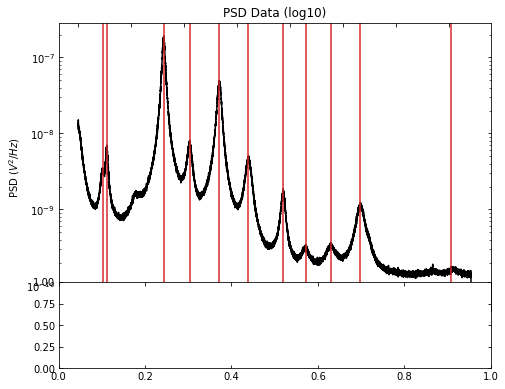

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


In [90]:
fit = fit_data(processed_data)
fit.canv()
fit.find_peaks(11, fit.plot1)
fit.fit_multipeak(0, 2, 0, 1e0, 1e4, 1)
fit.fig.show()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


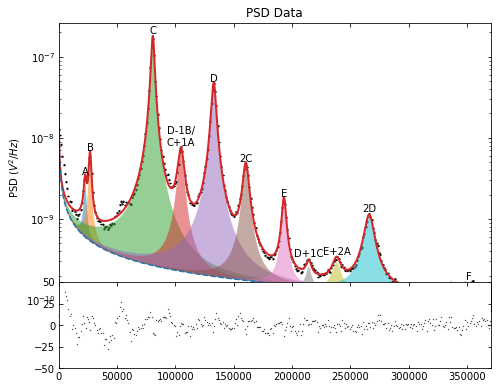

<Figure size 1500x525 with 0 Axes>

In [91]:
fit.canv()
fit.peak_identification()
fit.plot(fit.plot1, fit.plot2)
fit.fig.show()
fit.save(r"C:\Users\K19044739\OneDrive - King's College London\Documents\DataCode\multi-fit\code\Test","Test")